In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='rgby')

In [2]:
nfft = 2048
integrate = 1171
fs = 240e3
tstart = np.datetime64('2020-11-29T09:20:22.248176')

In [3]:
auto = np.array([[
    np.fromfile(f'/home/destevez/CE5/multichannel/CE5_2020-11-29T09:20:13.661224_0{pol}_{channel}.crossspec',
                dtype = 'float32').reshape((-1,nfft))
    for pol in ('xx', 'yy')] for channel in range(4)])
cross = np.array([
    np.fromfile(f'/home/destevez/CE5/multichannel/CE5_2020-11-29T09:20:13.661224_0xy_{channel}.crossspec',
                dtype = 'complex64').reshape((-1,nfft))
    for channel in range(4)])

gain_offset = np.average((np.median(auto[:,0], axis = 2)/np.median(auto[:,1], axis = 2)), axis = 1)
auto[:,1] *= gain_offset[:,np.newaxis,np.newaxis]
cross *= np.sqrt(gain_offset[:,np.newaxis,np.newaxis])
cross *= np.exp(-1j*np.deg2rad(-160))*(-1j) # correct for X-Y phase offset
# calibrated with Tianwen-1 2020-11-01

In [4]:
t = tstart + int(1e9 * integrate * nfft / fs) * np.timedelta64(1, 'ns') * np.arange(auto.shape[2])

In [5]:
signal_peak = np.argmax(auto[:,0] + auto[:,1], axis = 2)
offsets = np.arange(-2,3)
signal_auto = np.zeros((auto.shape[0], auto.shape[2], auto.shape[1]))
signal_cross = np.zeros((cross.shape[0], cross.shape[1]), dtype = 'complex')
for offset in np.arange(-2,3):
    signal_auto += auto[np.arange(signal_peak.shape[0])[:,np.newaxis],
                       :,
                       np.arange(signal_peak.shape[1])[np.newaxis,:],
                       signal_peak + offset]
    signal_cross += cross[np.arange(signal_peak.shape[0])[:,np.newaxis],
                       np.arange(signal_peak.shape[1])[np.newaxis,:],
                       signal_peak + offset]
signal_auto /= offsets.size
signal_cross /= offsets.size
gain_auto = np.average(signal_auto[:,:,0] + signal_auto[:,:,1])
signal_auto /= gain_auto
signal_cross /= gain_auto

In [6]:
I = signal_auto[:,:,0] + signal_auto[:,:,1]
Q = signal_auto[:,:,0] - signal_auto[:,:,1]
U = 2*signal_cross.real
V = -2*signal_cross.imag
L = Q + 1j*U
P = np.sqrt(Q**2 + U**2 + V**2)

In [7]:
freqs = [8463.7, 8671.2, 8478.6, 8486.2]
spacecrafts = ['lander', 'orbiter', 'lander', 'orbiter']
def set_legend():
    plt.legend([f'{f:.01f} MHz {s}' for f,s in zip(freqs, spacecrafts)])

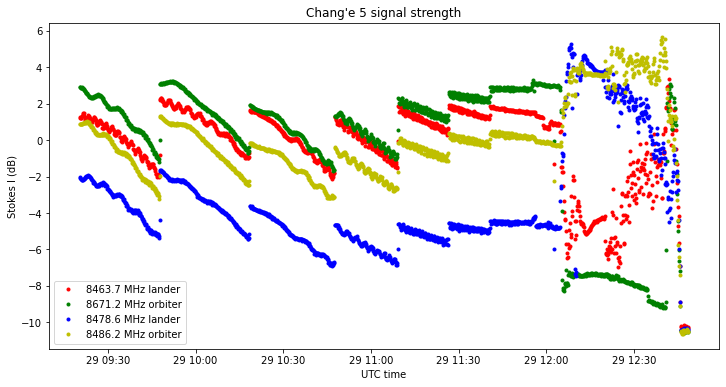

In [8]:
plt.figure(figsize = (12, 6))
plt.plot(t, 10*np.log10(I).T, '.')
set_legend()
plt.ylabel('Stokes I (dB)')
plt.xlabel('UTC time')
plt.title('Chang\'e 5 signal strength');

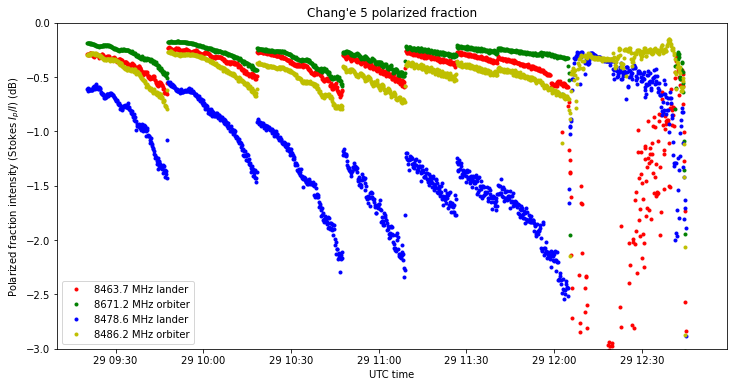

In [9]:
plt.figure(figsize = (12, 6))
plt.plot(t, 10*np.log10(P/I).T, '.')
plt.ylim((-3,0))
set_legend()
plt.ylabel('Polarized fraction intensity (Stokes $I_p/I$) (dB)')
plt.xlabel('UTC time')
plt.title('Chang\'e 5 polarized fraction');

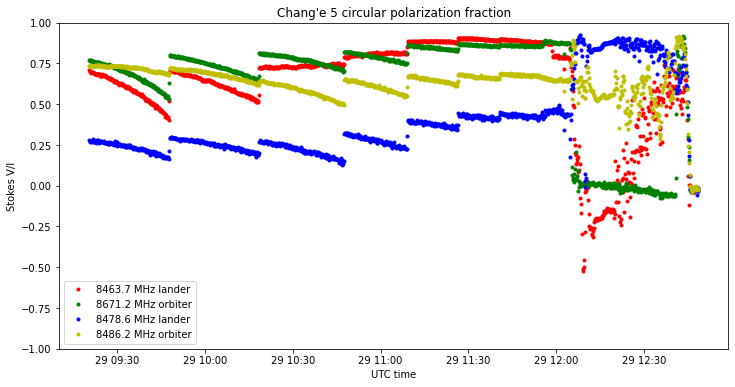

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(t, (V/I).T, '.')
set_legend()
plt.ylabel('Stokes V/I')
plt.xlabel('UTC time')
plt.ylim((-1,1))
plt.title('Chang\'e 5 circular polarization fraction');

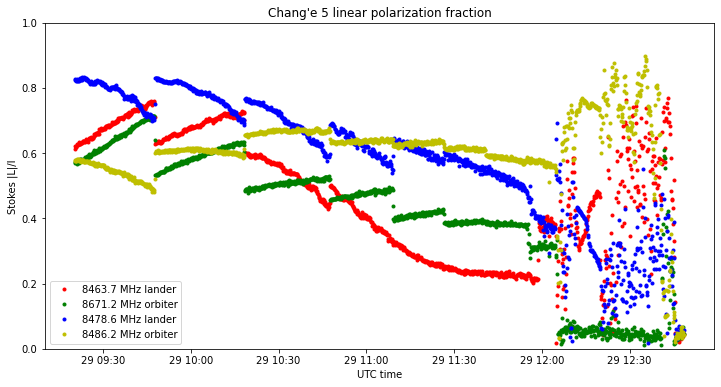

In [11]:
plt.figure(figsize = (12, 6))
plt.plot(t, (np.abs(L)/I).T, '.')
set_legend()
plt.ylabel('Stokes |L|/I')
plt.xlabel('UTC time')
plt.ylim((0,1))
plt.title('Chang\'e 5 linear polarization fraction');

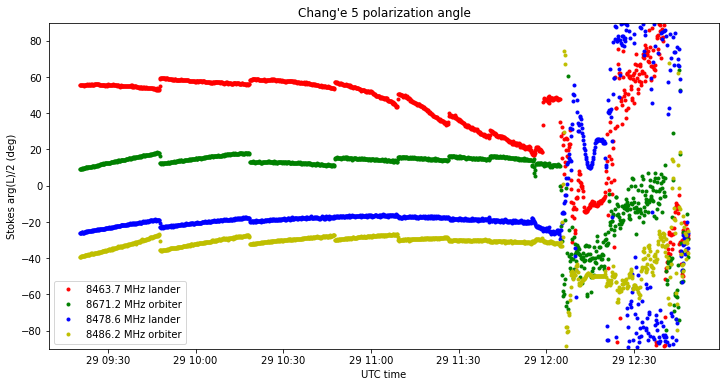

In [12]:
plt.figure(figsize = (12, 6))
plt.plot(t, np.rad2deg(np.angle(L)/2).T, '.')
plt.ylim((-90,90))
set_legend()
plt.ylabel('Stokes arg(L)/2 (deg)')
plt.xlabel('UTC time')
plt.title('Chang\'e 5 polarization angle');